In [1052]:
import frgtools.misc as frgm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')
import pandas as pd
import os
from scipy.optimize import curve_fit
from tqdm import tqdm

# Fitting Function

In [1053]:
# Using Rishi's CurveFitting Tool for Basic Parameters
def FitLight(v, i, area, diodes = 2, plot = False, init_guess = {}, bounds = {}, maxfev = 5000, type = None):
	"""
	Takes inputs of voltage (V), measured current (A), and cell area (cm2)

	Fits an illuminated JV curve to find at least the basic JV parameters:
	Open-circuit voltage: Voc (V)
	Short-circuit current: Jsc (mA/cm2)
	Max power point voltage: Vmpp (V)

	Fitting by 2-diode (default) or 1-diode model as specified by diodes argument provides additional parameters:
	Diode saturation currents: Jo1, (Jo2 if 2-diode model) (A/cm2)
	Series resistance: Rs (ohms cm2)
	Shunt resistance: Rsh (ohms)
	Photogenerated current: Jl (A/cm2)
	"""



	j = [i_/area for i_ in i]	#convert A to mA
	
# 	if max(j) > .05:
# 		print('Current seems too high (max = {0} mA/cm2). Please double check that your area (cm2) and measured current (A) are correct.'.format(max(j*1000)))

	v = np.asarray(v)
	j = np.asarray(j)

	j = j[v >= 0]
	v = v[v >= 0]
	v = v[j >= 0]
	j = j[j >= 0]
	
	p = np.multiply(v, j)
	x = np.vstack((v,j))
	
	jsc = j[np.argmin(np.abs(v))]

	if diodes == 2:
		init_guess_ = [1e-12, 1e-12, 2, 1e3, jsc] #jo1, jo2, rs, rsh, jl
		for key, val in init_guess.items():
			for idx, choices in enumerate([['jo1', 'j01'], ['jo2', 'j02'], ['rs', 'rseries'], ['rsh', 'rshunt'], ['jl', 'jill', 'jilluminated']]):
				if str.lower(key) in choices:
					init_guess_[idx] = val
					break

		bounds_=[[0, 0, 0, 0, jsc*0.9], [np.inf, np.inf, np.inf, np.inf, jsc*1.1]]
		for key, vals in bounds.items():
			for idx, choices in enumerate([['jo1', 'j01'], ['jo2', 'j02'], ['rs', 'rseries'], ['rsh', 'rshunt'], ['jl', 'jill', 'jilluminated']]):
				if str.lower(key) in choices:
					bounds_[0][idx] = vals[0]
					bounds_[1][idx] = vals[1]
					break

		best_vals, covar = curve_fit(_Light2Diode, x, x[1,:], p0 = init_guess_, maxfev = maxfev, bounds = bounds_, method = 'trf')
		
		results = {
			'jo1': best_vals[0],
			'jo2': best_vals[1],
			'rs': best_vals[2],
			'rsh': best_vals[3],
			'jl': best_vals[4],
			'covar': covar
		}
		results['jfit'] = _Light2Diode(x, results['jo1'], results['jo2'], results['rs'], results['rsh'], results['jl'])
	
	elif diodes == 1:
		init_guess_ = [1e-12, 2, 1e3, jsc] #jo1, rs, rsh, jl
		for key, val in init_guess.items():
			for idx, choices in enumerate([['jo1', 'j01'], ['rs', 'rseries'], ['rsh', 'rshunt'], ['jl', 'jill', 'jilluminated']]):
				if str.lower(key) in choices:
					init_guess_[idx] = val
					break
					
		bounds_=[[0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf]]
		for key, vals in bounds.items():
			for idx, choices in enumerate([['jo1', 'j01'], ['rs', 'rseries'], ['rsh', 'rshunt'], ['jl', 'jill', 'jilluminated']]):
				if str.lower(key) in choices:
					bounds_[0][idx] = vals[0]
					bounds_[1][idx] = vals[1]
					break
	
		print(init_guess_)
		print(bounds_)
		best_vals, covar = curve_fit(_Light1Diode, x, x[1,:], p0 = init_guess_, maxfev = maxfev, bounds = bounds_)
		
		results = {
			'jo1': best_vals[0],
			'rs': best_vals[1],
			'rsh': best_vals[2],
			'jl': best_vals[3],
			'covar': covar
		}
		results['jfit'] = _Light1Diode(x, results['jo1'], results['rs'], results['rsh'], results['jl'])
	else:
		print('Error: Invalid number of diodes requested for fitting. Diode must equal 1 or 2. User provided {0}. Diode equation not fit.'.format(diodes))
		results = {}



	if plot and len(results) > 0:
		fig, ax = plt.subplots()
		ax.plot(v, j*1000, label = 'Measured')
		xlim0 = ax.get_xlim()
		ylim0 = ax.get_ylim()
		ax.plot(v, results['jfit']*1000, linestyle = '--', label = 'Fit')
		ax.set_xlim(xlim0)
		ax.set_ylim(ylim0)
		ax.set_xlabel('Voltage (V)')
		ax.set_ylabel('Current Density (mA/cm2)')
		plt.show()
	
	results['voc'] = v[np.argmin(np.abs(j))]
	results['jsc'] = j[np.argmin(np.abs(v))]
	results['vmpp'] = v[np.argmax(p)]
	results['pce'] = p.max()*10
	results['ff'] = p.max() / (results['voc']*results['jsc'])	

	return results

def _Light2Diode(x, jo1, jo2, rs, rsh, jl):
	v = x[0]
	j_meas = x[1]
	
	#constants
	q = 1.60217662e-19 #coulombs
	k = 1.380649e-23 #J/K
	T = 298.15 #assume room temperature

	#calculation
	d1 = jo1 * np.exp((q*(v+(j_meas*rs)))/(k*T))
	d2 = jo2 * np.exp((q*(v+(j_meas*rs)))/(2*k*T))
	j = jl - d1 - d2 - (v+j_meas*rs)/rsh
	
	return j

def _Light1Diode(x, jo1, rs, rsh, jl):
	v = x[0]
	j_meas = x[1]
	
	#constants
	q = 1.60217662e-19 #coulombs
	k = 1.380649e-23 #J/K
	T = 298.15 #assume room temperature

	#calculation
	d1 = jo1 * np.exp((q*(v+(j_meas*rs)))/(k*T))
	j = jl - d1 - (v+j_meas*rs)/rsh
	
	return j

# Loading Raw Data File

In [1054]:
fids = []
for f in frgm.listdir('Data', display = False):
    if 'control' in f and '_rgb' not in f:
        continue
    fids.append(f)

In [1055]:
# Use either frgm tool to load the file path or replace "fids[0]" with your file path
# use regular csv read if you converted to csv
# df = pd.read_csv(fids[1], header=None) 
# otherwise use:
df = pd.read_csv(fids[0], delimiter="\t", header=None)
df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True)
row, col = df.shape

# Converting Raw Data to Dataframe

In [1056]:
Device = []
for n in range(1, col,3):
    Device.append(df.iloc[1,n])
    
Run = []
for n in range(1, col,3):
    Run.append(df.iloc[0,n])

Size = []
for n in range(1, col,3):
    Size.append(df.iloc[3,n])

Date = []
for n in range(1, col,3):
    Date.append(df.iloc[6,n])

Time = []
for n in range(1, col,3):
    Time.append(df.iloc[7,n])
    
Type = []
for n in range(1, col,3):
    Type.append(df.iloc[2,n])

data_tuples = list(zip(Device, Run, Type, Size, Date, Time))
    
Tracer = pd.DataFrame(data_tuples, columns=['Device','Run','Type','Size', 'Date', 'Time'])

Tracer["Voltage_string"] = np.nan
Tracer["Current_string"] = np.nan
Tracer["Power_string"] = np.nan
Tracer["Voltage"] = np.nan
Tracer["Current"] = np.nan
Tracer["Power"] = np.nan
Tracer["PCE"] = np.nan
Tracer["FF"] = np.nan
Tracer["Jsc"] = np.nan
Tracer["Voc"] = np.nan
Tracer["Vmpp"] = np.nan

In [1057]:
# Converting to object to hold arrays in a single cell
Tracer = Tracer.astype('object')

In [1058]:
# Size gathering
row1, col1 = Tracer.shape

In [1059]:
for n in range(0, col,3):
    Tracer.at[n/3,'Voltage_string']=df[n][12:].values.tolist()

for n in range(1, col,3):
    Tracer.at[(n-1)/3,'Current_string']=df[n][12:].values.tolist()
    
for n in range(2, col,3):
    Tracer.at[(n-2)/3,'Power_string']=df[n][12:].values.tolist()

#removing dark curves
Tracer=Tracer.dropna(subset=['Run'], how='any')
Tracer.reset_index(drop=True, inplace=True)
row1, col1 = Tracer.shape

# Looping the Curve Fitting Over Each Measurement

In [1060]:
for n in range(0, row1, 1):
    Tracer.at[n,'Voltage'] = np.array(Tracer.loc[n,'Voltage_string'], dtype=np.float32)
    Tracer.at[n,'Current'] = np.array(Tracer.loc[n,'Current_string'], dtype=np.float32)
    Tracer.at[n,'Power'] = np.array(Tracer.loc[n,'Power_string'], dtype=np.float32)
    
Tracer = Tracer.drop(['Voltage_string', 'Current_string', 'Power_string'], axis=1)

for t in tqdm(range(0, row1, 1)):
    try:
        temp_dict = FitLight(Tracer.loc[t]['Voltage'], Tracer.loc[t]['Current'], np.float(Tracer.loc[t]['Size']), diodes = 2, plot = False, init_guess = {}, bounds = {}, maxfev = 5000, type = None)
        temp_list = list(temp_dict.values()) 
        Tracer.at[t,'Voc']= temp_list[7]*1000
        Tracer.at[t,'Jsc']= temp_list[8]*1000
        Tracer.at[t,'Vmpp']= temp_list[9]*1000
        Tracer.at[t,'PCE']= temp_list[10]*100
        Tracer.at[t,'FF']= temp_list[11]*100
    except:
        print('line   ' + str(t) + '   is erroneous')
        pass
print('the rest should be ok')
# Really bad devices, and bugged measurements will give errors

 85%|████████▌ | 114/134 [00:01<00:00, 68.03it/s]/opt/anaconda3/envs/ds/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
100%|██████████| 134/134 [00:01<00:00, 69.50it/s]

line   124   is erroneous
line   126   is erroneous
line   128   is erroneous
line   131   is erroneous
line   133   is erroneous
the rest should be ok


# Creating a Subset Dataframe

In [1061]:
# Filtering out nonsensical FF
Tracer = Tracer[Tracer['FF'] < 100]  

# Filtering out failed devices
Tracer = Tracer[Tracer['PCE'] > 5]  

# Filtering out bugged curves (manual entry)
Tracer = Tracer[Tracer.Device != 'C5SASD1_P3_S1']
Tracer = Tracer[Tracer.Device != 'C9SASD2_P2_S2']
Tracer = Tracer[Tracer.Device != 'C9EASD1_P3_S1']
Tracer = Tracer[Tracer.Device != 'C5EASD1_P2_S1']
Tracer = Tracer[Tracer.Device != 'C9SASD1_P2_S1']
Tracer = Tracer[Tracer.Device != 'C5SASD2_P3_S1']
Tracer = Tracer[Tracer.Device != 'C9SASD2_P1_S1']

# Reseting index in master dataframe for clarity
Tracer.reset_index(drop=True, inplace=True)

# plotting a subset of experiment
# filter condition 1:
df_filter1 = Tracer[Tracer.Device.str.contains("9")]

# filter condition 2:
df_filter2 = df_filter1[df_filter1.Device.str.contains("SASD")]

# filter condition 3: #1 = reverse, #2 = forward, depends on actual settings when measurement taken
df_filter3 = df_filter2[df_filter2.Type.str.contains("2")]

df_filter3.reset_index(drop=True, inplace=True)

# observing your dataset before plotting
df_filter3

,Device,Run,Type,Size,Date,Time,Voltage,Current,Power,PCE,FF,Jsc,Voc,Vmpp
0,C9SASD1_P3_S1,(2 of 2),Illuminated IV2,0.07,3/12/2020,6:29:40 PM,"[-0.20107022, -0.19645989, -0.18471336, -0.175...","[0.0015316143, 0.0015280311, 0.0015303666, 0.0...","[-0.00030796204, -0.0003001968, -0.00028267916...",17.1119,75.4215,21.9371,1034.25,861.504
1,C9SASD1_P3_S2,(2 of 2),Illuminated IV2,0.07,3/12/2020,6:30:17 PM,"[-0.20356321, -0.1966825, -0.18516052, -0.1757...","[0.0015044122, 0.0015053173, 0.0015048028, 0.0...","[-0.000306243, -0.00029606954, -0.00027863006,...",15.2561,70.4663,21.4979,1007.09,814.556
2,C9SASD2_P1_S2,(2 of 2),Illuminated IV2,0.07,3/12/2020,6:34:58 PM,"[-0.21481754, -0.20019059, -0.19388454, -0.184...","[0.0016130671, 0.0016001149, 0.0015930269, 0.0...","[-0.00034651512, -0.00032032793, -0.0003088632...",11.7836,55.4981,21.5052,987.318,747.763
3,C9SASD2_P2_S3,(2 of 2),Illuminated IV2,0.07,3/12/2020,6:35:59 PM,"[-0.2130143, -0.20346706, -0.1947258, -0.18470...","[0.001607443, 0.0015953957, 0.0015877527, 0.00...","[-0.00034240834, -0.00032461045, -0.0003091764...",12.2328,57.9217,21.5886,978.27,710.893
4,C9SASD2_P3_S1,(2 of 2),Illuminated IV2,0.07,3/12/2020,6:36:19 PM,"[-0.21416849, -0.20286454, -0.19490713, -0.185...","[0.0016619107, 0.0016456845, 0.0016313442, 0.0...","[-0.00035592887, -0.00033385103, -0.0003179606...",8.413,45.6138,21.0534,876.057,588.898
5,C9SASD2_P2_S4,(2 of 2),Illuminated IV2,0.07,3/12/2020,6:36:43 PM,"[-0.21341418, -0.20388581, -0.1946303, -0.1843...","[0.00160689, 0.0015956877, 0.0015848281, 0.001...","[-0.0003429331, -0.0003253381, -0.00030845558,...",12.3085,58.7936,21.3837,979.018,737.876


# Plotting the Subset

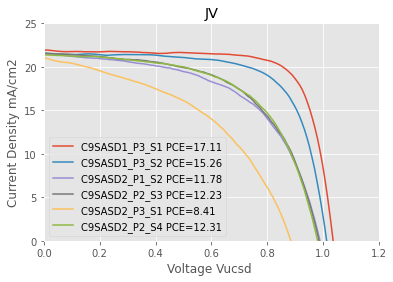

In [1062]:
# filtered DataFrame to Plot
DF = df_filter3 

for q in range (0, len(DF), 1):

    plt.plot(DF.loc[q]['Voltage'],DF.loc[q]['Current']/np.float(DF.loc[q]['Size'])*1000, label=DF.loc[q]['Device']+ ' PCE='+ str(round(DF.loc[q]['PCE'],2)))
#   plt.plot(DF.loc[q]['Voltage'],DF.loc[q]['Power']/np.float(DF.loc[q]['Size'])*1000, label=DF.loc[q]['Device']+' '+'Power Curve')

plt.legend()
plt.title('JV')
plt.ylim(0,25)
plt.xlim(0,1.2)

plt.ylabel('Current Density mA/cm2')
plt.xlabel('Voltage Vucsd ')
plt.show()

# Looking for Maximums

In [1063]:
maxlist = []
for n in range(np.size(Tracer['PCE'])):
        maxlist.append(round(Tracer['PCE'][n],2))

In [1064]:
m = max(maxlist)
[i for i, j in enumerate(maxlist) if j == m]

[38]

In [1065]:
Tracer[38:39]

,Device,Run,Type,Size,Date,Time,Voltage,Current,Power,PCE,FF,Jsc,Voc,Vmpp
38,C9SASD1_P3_S1,(2 of 2),Illuminated IV2,0.07,3/12/2020,6:29:40 PM,"[-0.20107022, -0.19645989, -0.18471336, -0.175...","[0.0015316143, 0.0015280311, 0.0015303666, 0.0...","[-0.00030796204, -0.0003001968, -0.00028267916...",17.1119,75.4215,21.9371,1034.25,861.504
